In [1]:
import os
import pickle
import shutil
import sys

import numpy as np
import matplotlib.pyplot as plt
import skimage.transform as trans
from skimage.io import imread
from sklearn.model_selection import train_test_split

sys.path.append('../../')
from preprocess import extract, preprocess, test_train_split

import warnings
warnings.filterwarnings("ignore")

# Extract Slices from raw LIDC_IDRI dataset

In [2]:
# 1.1 clear out old data
if os.path.exists('data/extracted'):
    shutil.rmtree('data/extracted')

In [3]:
# 1.2 extract (note: k is the number of non-tumor and tumor slices to take from each patient)
extract(sourcepath='data/raw/', destpath='data/extracted', k=4)

Extracting...20/20

False


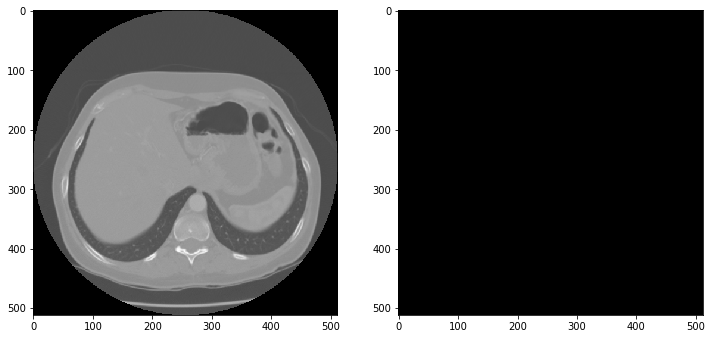

In [4]:
# 1.3: visualize
idx = np.random.randint(len(os.listdir('data/extracted/image')))

img = imread(f'data/extracted/image/{idx}.tif')  
mask = imread(f'data/extracted/mask/{idx}.tif') 
label = pickle.load(open(f"data/extracted/label/{idx}.pkl", "rb" ))

# print(idx)
print(label)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].imshow(np.array(img), cmap='gray')
axs[1].imshow(np.array(mask), cmap='gray')
plt.show()

# Process Extracted Slices

In [5]:
# Clear out old data
if os.path.exists('data/processed'):
    shutil.rmtree('data/processed')

In [6]:
# 2.2 process
preprocess(sourcepath='data/extracted', destpath='data/processed')

Processing...124/124
Complete.


104
False


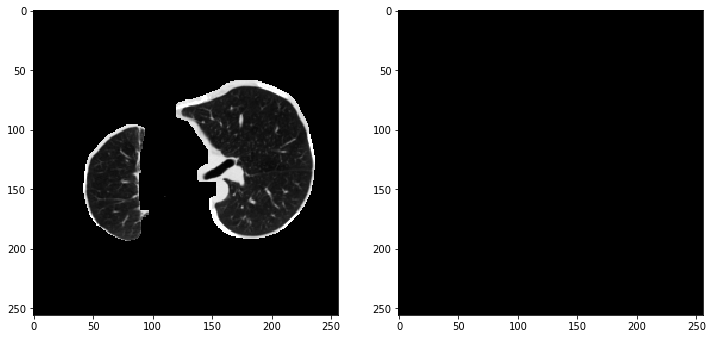

In [7]:
# 2.3: visualize

idx = np.random.randint(len(os.listdir('data/processed/image')))
img = imread(f'data/processed/image/{idx}.tif') 
mask = imread(f'data/processed/mask/{idx}.tif') 
label = pickle.load(open(f"data/processed/label/{idx}.pkl", "rb" ))

print(idx)
print(label)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].imshow(np.array(img), cmap='gray')
axs[1].imshow(np.array(mask), cmap='gray')
plt.show()

In [8]:
# 2.4 remove images with bad segmentations
bad_ims = []
for idx in os.listdir('data/processed/image'):
    im = imread(f'data/processed/image/{idx}') 
    mask = imread(f'data/processed/mask/{idx}') 
    mask_pixels = im.flatten()[np.argwhere(mask.flatten()>0)]
    # remove if < 50% of mask in image
    if np.count_nonzero(mask_pixels) < (5/10)*mask_pixels.size:
        bad_ims.append(idx)
    # remove if empty image returned from preprocessing
    elif im.sum() == 0:
        bad_ims.append(idx)

print(f"Number of bad images: {len(bad_ims)}")

if bad_ims:
    # visualize bad images
    bad_idx = bad_ims[np.random.randint(len(bad_ims))]
    bad_img = imread(f'data/processed/image/{bad_idx}') 
    bad_mask = imread(f'data/processed/mask/{bad_idx}') 

    print(bad_idx)

    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    axs[0].imshow(np.array(bad_img), cmap='bone')
    axs[1].imshow(np.array(bad_mask), cmap='bone')
    plt.show()

Number of bad images: 0


In [9]:
for bad_im in bad_ims:
    os.remove(f'data/processed/image/{bad_im}')
    os.remove(f'data/processed/mask/{bad_im}')

# Split into test, train and validation

In [10]:
# Clear out old data
if os.path.exists('data/train'):
    shutil.rmtree('data/train')
    shutil.rmtree('data/test')
    shutil.rmtree('data/val')

In [11]:
test_train_split('data/processed', 'data/train', 'data/test', 'data/val')

# Format for genki

In [12]:
train_ims = np.array([imread(f"data/train/image/{i}") for i in os.listdir('data/train/image/')])
train_masks = np.array([imread(f"data/train/mask/{i}") for i in os.listdir('data/train/image/')])
train_labels = np.array([pickle.load(open(f"data/train/label/{i}", "rb" )) for i in os.listdir('data/train/label/')])

val_ims = np.array([imread(f"data/val/image/{i}") for i in os.listdir('data/val/image/')])
val_masks = np.array([imread(f"data/val/mask/{i}") for i in os.listdir('data/val/image/')])
val_labels = np.array([pickle.load(open(f"data/val/label/{i}", "rb" )) for i in os.listdir('data/val/label/')])

test_ims = np.array([imread(f"data/test/image/{i}") for i in os.listdir('data/test/image/')])
test_masks = np.array([imread(f"data/test/mask/{i}") for i in os.listdir('data/test/image/')])
test_labels = np.array([pickle.load(open(f"data/test/label/{i}", "rb" )) for i in os.listdir('data/test/label/')])

In [13]:
print(train_ims.shape, train_labels.shape)
print(val_ims.shape, val_labels.shape)
print(test_ims.shape, test_labels.shape)

(76, 256, 256) (76,)
(16, 256, 256) (16,)
(32, 256, 256) (32,)


In [14]:
data = {
    'train_dataset': train_ims,
    'train_masks': train_masks,
    'train_labels': train_labels,
    'valid_dataset': val_ims,
    'val_masks': val_masks,
    'valid_labels': val_labels,
    'test_dataset': test_ims,
    'test_masks': test_masks,
    'test_labels': test_labels
}

In [15]:
pickle.dump(data, open('data/genki_data.pkl', 'wb'))